# Job Listings by Location

This notebook explores job listings in the United States. The listings here are a sample pulled from an XML feed from a job search platform. In production, several of these feeds, totalling over 40 GB uncompressed, are processed daily. When creating ads to drive traffic to a job search website, understanding which jobs are available on the platform is important. Job boards pay partners for each click.

While clicks are important, so are conversions. In this case, a converted click is one leading to a submitted application for a job. While a job search website desires high click rates, a job board may revoke access or remove certain jobs from a feed if there are high clicks but poor conversion rates. Therefore, matching the jobs advertised with the appropriate advertising medium is essential to a successful approach.

Here, a first effort is made to understand which jobs are present in the feed. Then some geographic vizualization is prepared as a tool for ad-creators and ad-ops specialsts.

For simplicity, only job title and location will be taken into account. The dataset containing title & location alone is over 150 MB.

In [1]:
import os
import folium
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def load_clean(path, file):
    '''Clean up dataframe for consistent processing
    
    Remove whitespance in column names
    
    Remove whitespace in each row
    '''
    df = pd.read_csv(os.path.join(path, file))
    cols = df.columns
    col_dict = {col:col.strip() for col in cols}
    df.rename(columns=col_dict, inplace=True)
    new_cols = df.columns
    for col in new_cols:
        df[col] = df[col].str.strip()
    return df

def fix_title(text):
    if isinstance(text, str):
        title = text.strip().casefold()
        if len(title) > 0:
            return title
        else:
            return title
    else:
        return np.nan

In [10]:
data_path = '../../job-partners/data/title_location/'
df = load_clean(data_path, 'title_loc_demo.csv')
df['title'] = df['title'].apply(fix_title)
df.columns

Index(['company', 'title', 'city', 'state'], dtype='object')

In [11]:
df.head()

,company,title,city,state
0,Domino's Pizza,warehouse team member,New Boston,MI
1,Home Depot,warehouse support,Tinley Park,IL
2,Amazon,warehouse team member (part-time flexible hours),Denver,CO
3,Amazon.com Inc.,web development engineer,Newark,NJ
4,Town Sports International Holdings Inc,welcome team member (front desk associate),Butler,NJ


In [14]:
print('There are {} jobs in today\'s feed'.format(df.shape[0]))
print('There are {} unique job titles'.format(len(df.title.unique())))

There are 1841084 jobs in today's feed
There are 798274 unique job titles


Let's get a sense of what the most popular job titles are:

In [13]:
df.title.value_counts().head()

sales associate                                          10521
assistant manager                                         9318
team member                                               8422
automotive tool sales / route manager - full training     7704
outside sales/route sales manager – full training         7273
Name: title, dtype: int64

Since we are intersted in geographically targeted advertizing, let's only consider jobs in the United States.

In [15]:
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

In [16]:
us_jobs = df[df.state.isin(states)]
us_jobs.head()

,company,title,city,state
0,Domino's Pizza,warehouse team member,New Boston,MI
1,Home Depot,warehouse support,Tinley Park,IL
2,Amazon,warehouse team member (part-time flexible hours),Denver,CO
3,Amazon.com Inc.,web development engineer,Newark,NJ
4,Town Sports International Holdings Inc,welcome team member (front desk associate),Butler,NJ


In [18]:
us_jobs.state.value_counts().head(11)

CA    201278
TX    144134
FL    101691
NY     88333
PA     75820
IL     75504
OH     67742
VA     66807
GA     60725
MA     58822
NC     58706
Name: state, dtype: int64

There is likely a good amount of overlap between job titles. It might be helpful to categorize jobs and filter them by type. For example, we can group all nursing jobs as 'nurse' and various types of software engineering roles as 'software engineer'. It's also helpful to make a distinction between more permanent, skilled roles and temporary/gig/side-income roles, as each is best targeted to different audiences and through different platforms.

In [17]:
def get_role(job_title, gig_only=False):
    '''Label each row by the type of job it is
    '''
    if gig_only:
        role_names = ['instacart','shipt','uber eats','uber','lyft',
                      'doordash','takl','care.com','taskrabbit', 
                      'guru','rover','hopskipdrive','fiverr',
                      'freelancer','favor delivery','bellhops',
                      'turo','vrbo','getaround','airbnb','taskeasy',
                      'zeel.com','amazon flex','grubhub','caviar',
                      'handy','dolly','postmates', 'wagl'
                      'delivery','upwork','server']
    else:
        role_names = ['crna','cna','registered nurse','nurse',
                  'physical therapist','speech therapist','pharmacist', 
                  'cdl','delivery','chef','cook','server', 
                  'devops engineer','machine learning engineer','software engineer',
                  'mechanical engineer','electrical engineer', 'systems engineer',
                  'business analyst', 'product manager']
    try:
        text = job_title.strip().casefold()
        for role in role_names:
            if role in text:
                return role
            else:
                pass
        return np.nan
    except:
        return np.nan

## Gig Economy Jobs

As mentioned earlier, job boards want conversions, not simply high click rates. Skilled positions are usually looking for individuals who are already employed. These individuals, such as nurses or engineers, are typically passive job seekers. Therefore, applications coming from these ads will be lower. On the other hand, gig-economy roles, such as Uber Drivers, Instacart Shoppers, etc, are attractive to a wider audience. These are great options for individuals looking to supplement their income, or support themselves as they seek other opportunities.  These roles are more suited for social media platform ads than more highly skilled positions.

In [19]:
gig_roles = us_jobs.copy()
gig_roles['role'] = gig_roles.title.apply(lambda x: get_role(job_title=x, gig_only=True))
gig_roles = gig_roles[~gig_roles.role.isna()]
gig_roles.role.value_counts()

server            17506
handy              2247
rover               232
uber                 84
freelancer           52
amazon flex          24
caviar               18
turo                  9
lyft                  9
airbnb                9
favor delivery        4
guru                  3
instacart             1
Name: role, dtype: int64

In [22]:
gig_roles[gig_roles.role=='favor delivery'].head()

,company,title,city,state,role
456210,Favor,favor delivery runner,Mesquite,TX,favor delivery
1024496,Favor,favor delivery runner,Irving,TX,favor delivery
1024497,Favor,favor delivery runner,Fort Worth,TX,favor delivery
1610135,Favor,favor delivery runner. - jollyville,Jollyville,TX,favor delivery


As we see below, our earlier method of labeling jobs is not perfect. In fact, it is quite unreliable. Order matters, and matches may be found apart from those we seek. It makes sense to take a more rigorous and thoughtful approaches, such as natural language processing to classify roles. We will explore this in subsequent notebooks.

In [21]:
gig_roles[gig_roles.role=='caviar'].head()

,company,title,city,state,role
684440,Square,caviar email marketing coordinator,New York,NY,caviar
764099,Square,caviar for companies support & logistics strat...,San Francisco,CA,caviar
775103,Square,product manager caviar (diners),San Francisco,CA,caviar
887479,Square,caviar restaurant partnership manager,Philadelphia,PA,caviar
954000,Square,product design lead caviar,San Francisco,CA,caviar


## By company

Searching for gig roles by company is also misleading. Many of these companies, such as Lyft, Uber, Instacart, etc, are primarily tech companies. Many of their roles are for highly skilled positions, such as software engineers, data scientists, and managers. Again, this emphasizes the need to explore natural language classification.

In [23]:
companies = ['instacart','shipt','uber eats','uber','lyft',
                      'doordash','takl','care.com','taskrabbit', 
                      'guru','rover','hopskipdrive','fiverr',
                      'freelancer','favor delivery','bellhops',
                      'turo','vrbo','getaround','airbnb','taskeasy',
                      'zeel','amazon flex','grubhub','caviar',
                      'handy','dolly','postmates', 'wagl']

gig_companies = us_jobs.copy()
gig_companies['company'] = gig_companies.company.apply(fix_title)
gig_companies = gig_companies[gig_companies.company.isin(companies)]
gig_companies.head()

,company,title,city,state
333,grubhub,sr. ruby on rails developer (relocation assist...,Boston,MA
421,doordash,senior manager enterprise partnerships,New York,NY
429,doordash,sr. manager merchant services,Phoenix,AZ
572,instacart,shift lead,Stafford,TX
1717,lyft,service mechanic - phoenix,Phoenix,AZ


In [24]:
gig_companies.company.value_counts()

lyft              423
instacart         347
rover             245
grubhub           176
postmates         114
doordash           97
getaround          51
shipt              49
turo               27
hopskipdrive       16
care.com           13
taskrabbit          6
handy               2
favor delivery      2
Name: company, dtype: int64

## All Jobs 

Let's take a step back and look at all available roles in the job feed. We can see that the most common roles are nurses, CDL drivers, food service roles, and software engineers. 

Getting a sense of which jobs are popular with respect to location is important for targeted advertising. For example, there may be more CDL positions in the midwest, whereas Software rols may be more popular along the coasts.

In [25]:
us_roles = us_jobs.copy()
us_roles['role'] = us_roles.title.apply(get_role)
us_roles.role.value_counts()

cdl                          42772
nurse                        28792
cook                         28592
registered nurse             25070
delivery                     22997
server                       17413
software engineer            12936
physical therapist           11288
cna                           9790
systems engineer              4654
product manager               4227
business analyst              3099
pharmacist                    2770
chef                          2275
electrical engineer           1879
mechanical engineer           1489
devops engineer               1076
crna                           620
speech therapist               487
machine learning engineer      244
Name: role, dtype: int64

Breaking roles down by state is helpful, but there is too much too look at here. Let's focus on the largest states.

In [26]:
all_state_role_df = us_roles.groupby('role').state.value_counts().unstack()
all_state_role_df.T.head()

role,business analyst,cdl,chef,cna,cook,crna,delivery,devops engineer,electrical engineer,machine learning engineer,mechanical engineer,nurse,pharmacist,physical therapist,product manager,registered nurse,server,software engineer,speech therapist,systems engineer
state,,,,,,,,,,,,,,,,,,,,
AK,2.0,17.0,17.0,5.0,49.0,NaN,39.0,NaN,2.0,NaN,3.0,81.0,7.0,112.0,1.0,22.0,18.0,3.0,1.0,6.0
AL,25.0,1674.0,20.0,53.0,416.0,7.0,481.0,4.0,38.0,NaN,33.0,356.0,34.0,294.0,9.0,466.0,238.0,156.0,13.0,115.0
AR,11.0,506.0,6.0,116.0,268.0,10.0,273.0,2.0,6.0,1.0,6.0,238.0,22.0,123.0,10.0,141.0,116.0,112.0,4.0,22.0
AZ,51.0,346.0,64.0,125.0,692.0,4.0,435.0,19.0,48.0,NaN,27.0,546.0,74.0,254.0,37.0,815.0,383.0,175.0,21.0,97.0
CA,350.0,1140.0,262.0,933.0,2464.0,11.0,1894.0,240.0,236.0,104.0,262.0,2453.0,287.0,832.0,1212.0,1667.0,1394.0,3280.0,62.0,689.0


In [27]:
top_states = us_jobs.state.value_counts().head(11).index.values
state_role_df = us_roles[us_roles.state.isin(top_states)].groupby('role').state.value_counts().unstack()
state_role_df

state,CA,FL,GA,IL,MA,NC,NY,OH,PA,TX,VA
role,,,,,,,,,,,
business analyst,350.0,126.0,141.0,197.0,152.0,87.0,188.0,91.0,96.0,245.0,232.0
cdl,1140.0,1536.0,2242.0,2218.0,541.0,1405.0,1356.0,2708.0,2690.0,2432.0,523.0
chef,262.0,130.0,76.0,72.0,80.0,52.0,78.0,43.0,94.0,249.0,64.0
cna,933.0,594.0,181.0,317.0,268.0,424.0,230.0,187.0,308.0,858.0,412.0
cook,2464.0,2285.0,956.0,1127.0,524.0,965.0,785.0,1146.0,1078.0,2803.0,862.0
crna,11.0,33.0,12.0,38.0,14.0,44.0,42.0,32.0,27.0,43.0,17.0
delivery,1894.0,1358.0,978.0,995.0,593.0,1027.0,628.0,1022.0,623.0,2151.0,764.0
devops engineer,240.0,31.0,33.0,59.0,62.0,29.0,75.0,25.0,33.0,81.0,93.0
electrical engineer,236.0,78.0,37.0,88.0,98.0,48.0,58.0,74.0,69.0,135.0,97.0


Taking a more granular approach for larger states is also necessary. There are more software roles in SF than LA, unsurprisingly.

In [28]:
ca_cities = ['Los Angeles', 'San Francisco']
us_roles[(us_roles.state=='CA') & ((us_roles.city.isin(ca_cities)))].groupby('city')['role'].value_counts()

city           role                     
Los Angeles    registered nurse             199
               nurse                        161
               software engineer            116
               cook                         100
               delivery                      67
               cna                           65
               server                        58
               product manager               46
               pharmacist                    38
               systems engineer              30
               business analyst              29
               cdl                           29
               chef                          24
               physical therapist            24
               electrical engineer           13
               mechanical engineer           12
               devops engineer               11
               machine learning engineer      4
               crna                           1
               speech therapist               1

## Maps

Trying to determine job popularity by role and state by looking at a large matrix is difficult. Visual representations of the same data may prove more fruitful. While heatmaps are helpful, interactive geographic maps are even more intuitive to the typical user.

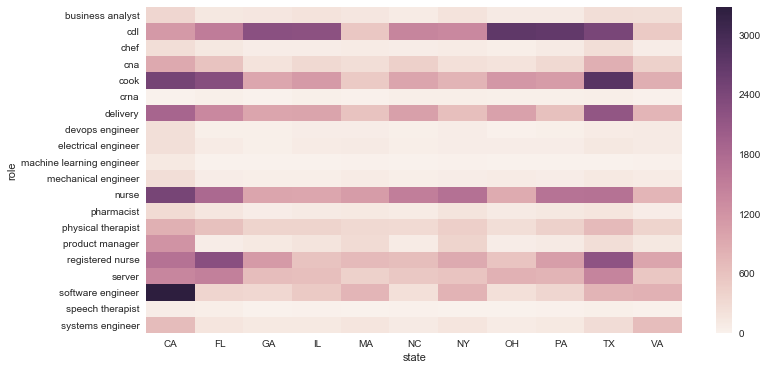

In [44]:
import seaborn as snss
plt.figure(figsize=(12,6))
sns.heatmap(state_role_df.fillna(0))

First, we can look at overall job totals across the US

In [40]:
state_totals = pd.DataFrame(us_jobs['state'].value_counts())
state_totals.rename(columns={'state':'jobs'}, inplace=True)
state_totals['state'] = state_totals.index 
state_totals.head()

,jobs,state
CA,201278,CA
TX,144134,TX
FL,101691,FL
NY,88333,NY
PA,75820,PA


In [42]:
us_map = folium.Map([43, -100], tiles='Mapbox Bright', zoom_start=4)
us_map.choropleth(geo_data='../../resources/us-states-folium.json', data=state_totals,
             columns=['state', 'jobs'],
             key_on='feature.id',
             threshold_scale=[0, 50000, 100000, 150000, 200000],
             fill_color='BuPu')
# folium maps do not display on GitHub, png used below
#us_map 

### Total job listings by state

![US Jobs](img/us_jobs.png)

We can also look at individual roles across the US

In [29]:
role_totals = state_role_df.T.fillna(0)
role_totals['total jobs'] = role_totals.sum(axis=1)
role_totals['state'] = role_totals.index

In [39]:
role_totals['nurse'].sort_values(ascending=False).head()

state
CA    2453.0
FL    1830.0
NY    1680.0
TX    1674.0
PA    1654.0
Name: nurse, dtype: float64

For example, we can see that nursing jobs are especially plentiful in New York, Florida, Texas, Pennsylvania, and California.

In [37]:
nurse_map = folium.Map([43, -100], tiles='Mapbox Bright', zoom_start=4)
nurse_map.choropleth(geo_data='../../resources/us-states-folium.json', data=role_totals,
             columns=['state', 'registered nurse'],
             key_on='feature.id',
             threshold_scale=[0, 500, 1000, 1500, 2000],
             fill_color='BuPu')
# folium maps do not display on GitHub, png used below
#nurse_map

### Nursing job listings by State

![US Nursing Jobs](img/us_nurses.png)

## Preliminary Ad Testing

An initial set of campaigns sought to evaluate the performance of ads for various roles. We chose to target the following roles:

+ Nurses
+ Drivers
+ Shoppers

We found that the ads for nursing jobs resulted in higher swipe-up rates, but were overall more expensive per result. Given that the cost per swipe (19 cents) was higher than the cost-per-click paid by the job partner, these ads were paused in favor of the other campaigns, which were below the payment threshold, and therefore, profitable.

It should be noted that the nursing ads were run for a shorter period than the driver and shopper ads.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

First, the campaign data is imported and cleaned up.

In [2]:
campaigns = pd.read_csv('../data/performance/demo/campaigns-demo.csv')
campaigns['Date'] = pd.to_datetime(campaigns['Start time'])

cols_to_keep = ['partner','role','skilled','Date', 'Campaign Name', 'Spend', 
                'Paid Impressions', 'Paid eCPM', 'Swipe Ups', 'eCPSU']

cols_performance = ['Spend', 'Paid Impressions', 
                'Paid eCPM', 'Swipe Ups', 'eCPSU']

campaigns['partner'] = campaigns['Campaign Name'].apply(lambda x: x.split('-')[0])
campaigns['role'] = campaigns['Campaign Name'].apply(lambda x: x.split('-')[1])
campaigns['skilled'] = campaigns.role==' Nurse'
campaigns = campaigns[cols_to_keep]                         

Campaigns are grouped according to job role, as multiple campaigns were run for the same job, but featuring different ads based on job partners.

In [3]:
role_totals = campaigns.groupby('role')[cols_performance].sum()
role_totals['CPI'] = role_totals['Spend']/role_totals['Paid Impressions']
role_totals['CPS'] = role_totals['Spend']/role_totals['Swipe Ups']
role_totals['Swipe Rate'] = role_totals['Swipe Ups']/role_totals['Paid Impressions']
role_totals

,Spend,Paid Impressions,Paid eCPM,Swipe Ups,eCPSU,CPI,CPS,Swipe Rate
role,,,,,,,,
Driver,743.42,265993,77.24,5196,3.88,0.002795,0.143075,0.019534
Nurse,156.61,35751,30.66,793,1.36,0.004381,0.197491,0.022181
Shopper,1373.62,485648,75.27,9797,3.71,0.002828,0.140208,0.020173


### Cost by Role

We look at two cost metrics:

+ Cost per impression
+ Cost per swipe

These give us a sense of how much it costs to acquire our audience and generate clicks. These follow a similar trend for all roles. Nursing jobs show a clearly higher cost for both impressions and swipes compared to drivers and shoppers.

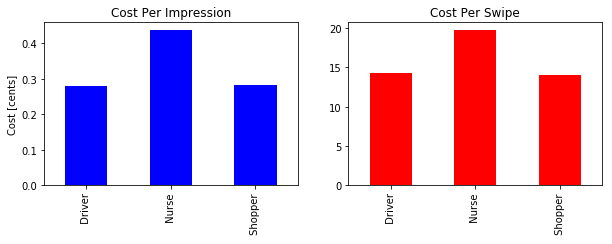

In [4]:
fig = plt.figure(figsize=(10,3))

cols_to_plot = ['CPI', 'CPS']
colors = {'CPI':'b','CPS':'r'}
labels = {'CPI':'Impression','CPS':'Swipe'}

i = 1

for col in cols_to_plot:
    plt.subplot(1, 2, i)
    (role_totals[col]*100).plot(kind='bar', color=colors[col])
    plt.title('Cost Per '+ labels[col])
    plt.xlabel('')
    if i == 1:
        plt.ylabel('Cost [cents]')
    else:
        pass
    i += 1

plt.show()

### Swipe Rate

While nurse targeting ads cost more, they are a bit more effective in generating clicks. 

It should be noted, again, that the sample size for nursing roles was much smaller than the other two groups. So a more statistical approach should be considered when comparing the groups. For now, however, we have chosen to focus on gig-roles for a number of reasons, including the lower cost.

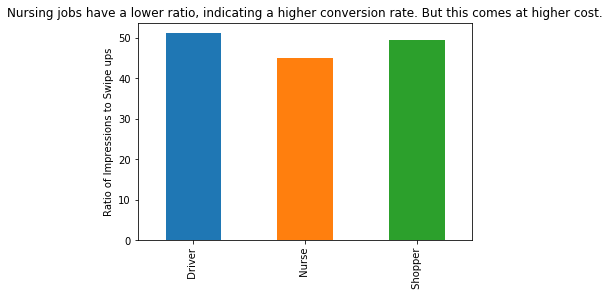

In [5]:
(role_totals['Paid Impressions']/role_totals['Swipe Ups']).plot(kind='bar')
plt.ylabel('Ratio of Impressions to Swipe ups')
plt.title('Nursing jobs have a lower ratio, indicating a higher conversion rate. But this comes at higher cost.')
plt.xlabel('')
plt.show()